# Model the stellar I2 observations

## Background

If you've completed the last tutorial [and created a deconvolved stellar template](./template.ipynb), we can now use that to model I2 observations of our star. This means: observations of the star conducted with the I2 cell in the light path, so that the stellar and I2 spectrum are both recorded together. The resulting spectrum $I_*(x)$ can then be modelled by a combination of the deconvolved stellar template $T_*(\lambda)$, the I2 template $T_\mathrm{I2}(\lambda)$, a LSF model $L(x)$, and a continuum model $k(x)$:

$$
    \hat{I}_*(x) = k(x) \cdot \Big[ T_\mathrm{I2}\big(\lambda(x)\big) \cdot T_*\big(\lambda(x) \cdot (1 + v/c)\big) \Big] * L(x)
$$

As you can see, the deconvolved stellar template is shifted in wavelength by a factor $(1 + v/c)$, where $v$ is the relative radial velocity between the observation and the template. So, in words: The I2 atlas gives us a measure to constrain the wavelength model and consequently detect the relative wavelength shift between observation and template.

Again, all this is done in chunks to reduce complexity.

## Run the code

Again, first let's set up the path and import the required packages (don't forget: change the pathname when running it on your machine):

In [2]:
# Automatic reloading of imports
%load_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt
import numpy as np

# Put in the pyodine path on your machine here!
pyodine_path = '/home/paul/pyodine/'

sys.path.append(pyodine_path)

import pyodine
import pyodine_model_observations       # <- the observation modelling routines

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


And, as before, import the utilities module and the parameter input object (this time not `Template_Parameters`, but `Parameters`):

In [3]:
import utilities_song as utilities

Pars = utilities.pyodine_parameters.Parameters()

Now we define the pathnames of the input data and output results: first the observation filenames, and for each single observation we need to specify the pathname of the deconvolved stellar template to use for it; in our case it's always the same (as all observations are of the same star), but this structure allows also to model observations from different stars in the same go (useful e.g. when analyzing all observations of an observing night). Also we define plot directories and results filenames (now we save all in HDF5 - this takes up much less memory than when using **dill**):

In [5]:
# Observations to model
obs_dir = os.path.join(pyodine_path, 'tutorial_data/sigdra_obs_tutorial')
obs_files = [os.path.join(obs_dir, f) for f in os.listdir(obs_dir)]
obs_files.sort()

# Deconvolved stellar template to use
temp_file = os.path.join(pyodine_path, 'tutorial_data/temp_results/temp_sigdra_2018-05-16.h5')
temp_files = [temp_file] * len(obs_files)

# Output directories for plots, log files, and output pathnames for modelling results
plot_dir_parent = os.path.join(pyodine_path, 'tutorial_data/obs_results')
plot_dirs = []
error_files = []
info_files = []
res_files = []
for obs_file in obs_files:
    # Plot directories
    plot_dir_base = os.path.splitext(os.path.basename(obs_file))[0]
    plot_dirs += [os.path.join(plot_dir_parent, plot_dir_base)]
    
    # Log files
    error_files += [os.path.join(plot_dirs[-1], 'error.log')]
    info_files  += [os.path.join(plot_dirs[-1], 'info.log')]
    
    # Result files
    res_files.append([os.path.join(plot_dirs[-1], plot_dir_base + '_res0.h5'), 
                      os.path.join(plot_dirs[-1], plot_dir_base + '_res1.h5')])

And with that done, we can model the first observation to get an idea of what's going on. For that, we use the function `model_single_observation`, and only hand in the first entry of all the created pathname arrays above:

In [6]:
pyodine_model_observations.model_single_observation(
    utilities, Pars, obs_files[0], temp_files[0], 
    plot_dir=plot_dirs[0], res_names=res_files[0],
    error_log=error_files[0], info_log=info_files[0])


Branch: master
Hash: 7dc6779
---------------------------
Working on: /home/paul/pyodine/tutorial_data/sigdra_obs_tutorial/s1_2015-05-02T03-48-48_ext.fits

Median flux of the observation: 31774
Loading template from file: /home/paul/pyodine/tutorial_data/temp_results/temp_sigdra_2018-05-16.h5

Order correction: -1

Measured velocity rel. to reference spectrum: 26.632 km/s
Template velocity: 25.136 km/s
Velocity guess: 1.495 km/s (relative to template)

(Barycentric velocity of observation: 0.894 km/s)
(Barycentric velocity of template: 2.026 km/s)


Barycentric redshift between template and observation: 
v = 1131.4373999999998, z = 3.7740689260434957e-06


Number of chunks: 528
In lowest order: 22
Orders: 17 - 40

----------------------
RUN 0
----------------------

Constraining parameters for RUN 0

Number of chunks with no uncertainties: 0
Number of chunks with outliers: 0
Number of chunks with nan fitted red. Chi2: 0

Creating analysis plots...

----------------------
RUN 1
--------

Great, let's again have a look at the output:

- In the beginning, after input pathnames and the median flux of the observation are mentioned, an 'order correction' of -1 is reported - this tells us that with regard to the observation that the deconvolved template was constructed from, the extracted Echelle orders seem to have shifted by one position.

- Next, the velocity guess of the observation with respect to a reference spectrum (cross-correlation with Arcturus or Sun spectrum) is printed, along with the reference velocity of the stellar template, and the relative velocity between both - this serves as first guess of the model velocity $v$.

- Also, the barycentric velocities of the observation and stellar template are printed (taken from the original `fits`-headers) - the difference between both is used to find the chunk positions in the observation spectrum.

- The next print outputs are very much the same as in the [template creation routine](./template.ipynb).

- Finally, some information about the best-fit results for the chunk velocities ($v$) is given.

## Inspecting the fit results of an observation

Now let's quickly take a look at the results of the second run (RUN 1) for this observation:

In [7]:
# Restore the RUN 1 fit results for the first observation
chunks, fit_results = pyodine.fitters.results_io.restore_results_object(
    utilities, res_files[0][1])

Loading template from file: /home/paul/pyodine/tutorial_data/temp_results/temp_sigdra_2018-05-16.h5
Order correction: -1


Barycentric redshift between template and observation: 
v = 1131.4373999999998, z = 3.7740689260434957e-06

Total number of created chunks: 528 (in result file: 528)
Number of created chunks per order: 22


We again plot the data and best-fit model for one chunk - this time setting `template=True` in the function, to also display the stellar template data of that chunk:

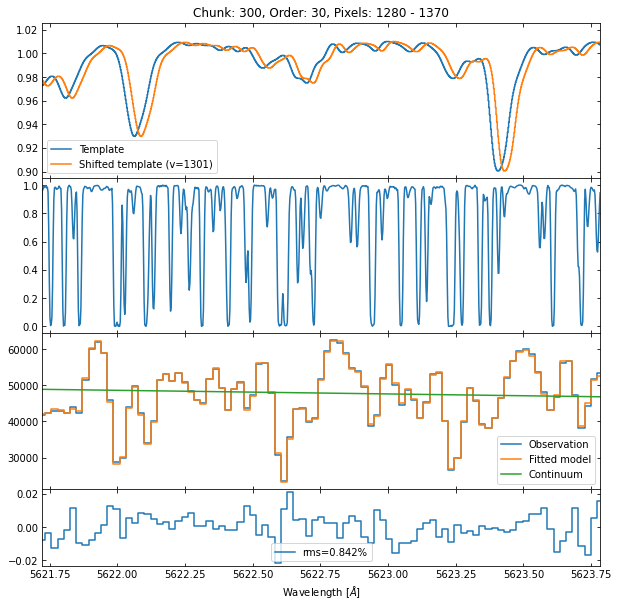

In [8]:
# Chunk index
chunk_ind = 300

pyodine.plot_lib.plot_chunkmodel(fit_results, chunks, chunk_ind, template=True, 
                                 show_plot=True)

Great, and let's also check out the residuals of all chunks:

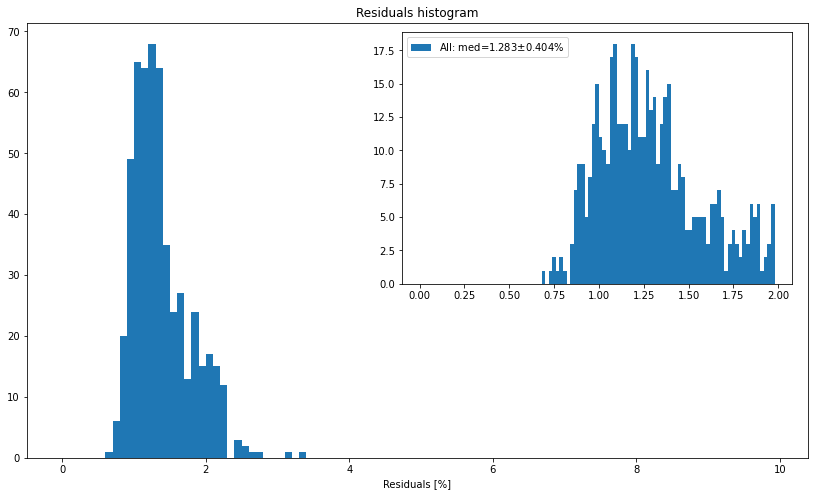

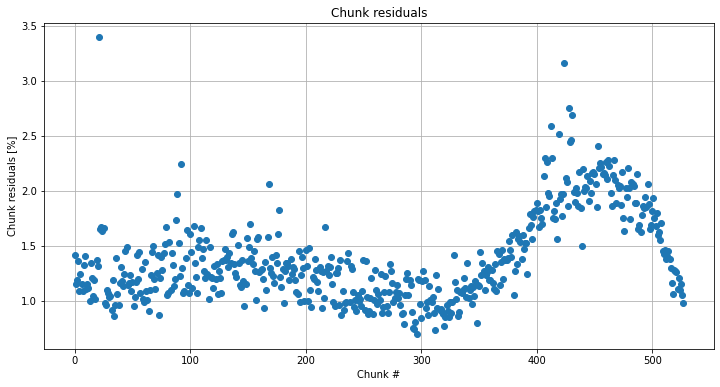

In [9]:
# Plot the histogram of residuals
residuals = pyodine.plot_lib.plot_residual_hist(fit_results, title='Residuals histogram', 
                                                show_plot=True)
# Plot the scatter of residuals
pyodine.plot_lib.plot_chunk_scatter(scatter=residuals, ylabel='Chunk residuals [%]', 
                                    title='Chunk residuals', show_plot=True)

Finally, it would be interesting to see the best-fit velocity results for all chunks, wouldn't it?

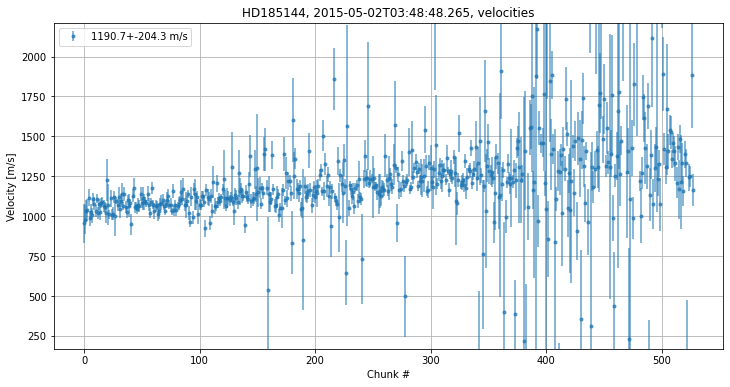

In [10]:
# Fetch observation info
star_name = chunks[0].observation.star.name
obs_date  = chunks[0].observation.time_start.value

# Fetch the velocities and and their fit uncertainties
velocities = np.array([r.params['velocity'] for r in fit_results])
vel_errors = [r.errors['velocity'] for r in fit_results]

# Compute robust mean and std
vel_med = pyodine.timeseries.misc.robust_mean(velocities)
vel_std = pyodine.timeseries.misc.robust_std(velocities)

# And plot (in constraint y-range)
pyodine.plot_lib.plot_chunk_scatter(
    errorbar=velocities, errorbar_yerr=vel_errors, errorbar_alpha=0.7, 
    errorbar_label='{:.1f}+-{:.1f} m/s'.format(vel_med, vel_std),
    yrange=(vel_med-5*vel_std, vel_med+5*vel_std),
    ylabel='Velocity [m/s]', title='{}, {}, velocities'.format(star_name, obs_date), 
    grid=True, show_plot=True
)

There is quite some scatter and large uncertainties at high chunk indices, i.e. red wavelengths, and also a linear trend throughout the chunks is apparent. Nevertheless, we will be able to generate quite good RVs out of these results, as you will see [in the next chapter](./velocities.ipynb).

## Run the code on many observations

We have seen now how to model a single observation, and what the results look like. For a timeseries however we need multiple observations, and to model these you can use the function `model_multi_observations` - it parallelizes the tasks to accelerate the whole procedure. With the attribute `number_cores` of your parameter object `Pars` you can control how many separate processes are created - right now it is set to 4, but better check your computing power before you run the code!

With that said, let's model the remaining observations (but in quiet mode, without terminal output).

In [11]:
pyodine_model_observations.model_multi_observations(
    utilities, Pars, obs_files[1:], temp_files[1:], 
    plot_dirs=plot_dirs[1:], res_files=res_files[1:], 
    error_files=error_files[1:], info_files=info_files[1:], quiet=True)


Done, full working time:  1549.243750333786
